In [331]:
# Data handling and manipulation
import pandas as pd              # For loading and managing your CSV (1682 rows)
import numpy as np               # For array operations (sequences, calculations)
import matplotlib.pyplot as plt
import joblib
import random
# Preprocessing
from sklearn.preprocessing import MinMaxScaler  # To scale data to 0–1 for LSTM

# LSTM modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential  # To build the LSTM model
from tensorflow.keras.layers import LSTM, Dense, Dropout # LSTM layers and output layer
from tensorflow.keras.optimizers import Adam    # Optimizer (optional tweak)
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
# Visualization
import plotly.graph_objects as go  # For interactive plots of predictions vs. actuals

# Evaluation (optional, but useful)
from sklearn.metrics import mean_squared_error  # To calculate RMSE

In [332]:
SEED = 7
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [333]:
def load_data(file_path):
    """
    Load the preprocessed COVID dataset from a CSV file.
    
    Args:
        file_path (str): Path to your CSV file (e.g., 'your_country_covid_data.csv')
    
    Returns:
        pd.DataFrame: Loaded dataset with date as datetime
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])  # Ensure date is in datetime format
    return df

In [334]:
def select_features(df, features):
    """
    Select features without differencing.
    
    Args:
        df (pd.DataFrame): Loaded dataset
        features (list): Columns to process (e.g., ['new_cases_smoothed', 'reproduction_rate'])
    
    Returns:
        pd.DataFrame: Selected dataset with original values
    """
    df_selected = df[['date'] + features].copy()
    return df_selected

In [335]:
def timeseries_to_supervised(data, lag=14):
    df = pd.DataFrame(data)
    
    print(f"🔍 Original Data Shape: {df.shape}")  # Debugging step 1

    # Create lagged columns
    columns = [df.shift(i) for i in range(lag, 0, -1)]
    columns.append(df)
    
    df_supervised = pd.concat(columns, axis=1).dropna()  # Drop NaN rows

    print(f"🔍 Supervised Data Shape: {df_supervised.shape}")  # Debugging step 2

    supervised_values = df_supervised.values
    X = supervised_values[:, :-df.shape[1]]  # Input features
    y = supervised_values[:, -df.shape[1]:][:, 0]  # Target variable

    print(f"✅ X shape before reshaping: {X.shape}")  # Expected: (n_samples, lag * features)
    print(f"✅ y shape: {y.shape}")  # Expected: (n_samples,)

    # Reshape to (samples, lag, features)
    try:
        X = X.reshape((X.shape[0], lag, df.shape[1]))
        print(f"✅ Reshaped X shape: {X.shape}")  # Expected: (n_samples, lag, n_features)
    except ValueError as e:
        print(f"❌ Reshape Error: {e}")
        print(f"Expected shape: ({X.shape[0]}, {lag}, {df.shape[1]}) but got {X.shape}")
        return None, None  # Return None to avoid crashing the program

    return X, y


In [336]:
def split_train_test(X, y, dates, test_year=2024, lag=14):
    """
    Split supervised data into train and test sets based on year.

    Args:
        X (np.ndarray): Supervised input data
        y (np.ndarray): Target data
        dates (pd.Series): Date column aligned with original data
        test_year (int): Year to use as test set
        lag (int): Number of past days considered as features

    Returns:
        np.ndarray: X_train, X_test, y_train, y_test
    """
    # Ensure dates align with X and y (shift by lag)
    dates = dates[lag:].reset_index(drop=True)  

    train_mask = dates.dt.year < test_year
    test_mask = dates.dt.year == test_year

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    return X_train, X_test, y_train, y_test


In [337]:
def scale(X_train, X_test, y_train, y_test):
    """
    Scale train and test data for LSTM using MinMaxScaler.

    Args:
        X_train (np.ndarray): Training input data
        X_test (np.ndarray): Test input data
        y_train (np.ndarray): Training target data
        y_test (np.ndarray): Test target data

    Returns:
        scaler_X: Fitted scaler for X
        scaler_y: Fitted scaler for y
        X_train_scaled (np.ndarray): Scaled X_train
        X_test_scaled (np.ndarray): Scaled X_test
        y_train_scaled (np.ndarray): Scaled y_train
        y_test_scaled (np.ndarray): Scaled y_test
    """
    # Reshape X to 2D for scaling
    n_train_samples, lag, n_features = X_train.shape
    n_test_samples = X_test.shape[0]

    X_train_2d = X_train.reshape(n_train_samples * lag, n_features)
    X_test_2d = X_test.reshape(n_test_samples * lag, n_features)

    # Fit scaler only on training data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled_2d = scaler_X.fit_transform(X_train_2d)
    X_test_scaled_2d = scaler_X.transform(X_test_2d)  # Use transform, not fit_transform

    # Reshape back to 3D
    X_train_scaled = X_train_scaled_2d.reshape(n_train_samples, lag, n_features)
    X_test_scaled = X_test_scaled_2d.reshape(n_test_samples, lag, n_features)

    # Scale y
    y_train_2d = y_train.reshape(-1, 1)
    y_test_2d = y_test.reshape(-1, 1)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    y_train_scaled = scaler_y.fit_transform(y_train_2d).ravel()
    y_test_scaled = scaler_y.transform(y_test_2d).ravel()  # Use transform, not fit_transform

    return scaler_X, scaler_y, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled


In [338]:
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', return_sequences=True, input_shape=input_shape),
        LSTM(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

In [339]:
def plot_results(y_test, y_pred):
    plt.figure(figsize=(10, 5))
    plt.plot(y_test, label="Actual", color='blue')
    plt.plot(y_pred, label="Predicted", color='red', linestyle='dashed')
    plt.xlabel("Time")
    plt.ylabel("Target Value")
    plt.legend()
    plt.title("Actual vs. Predicted")
    plt.show()

🔍 Original Data Shape: (1681, 6)
🔍 Supervised Data Shape: (1667, 90)
✅ X shape before reshaping: (1667, 84)
✅ y shape: (1667,)
✅ Reshaped X shape: (1667, 14, 6)
Epoch 1/100


d:\[2] My Projects\LSTM\myenv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


91/91 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1749 - val_loss: 4.7851e-04
Epoch 2/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038 - val_loss: 1.6950e-04
Epoch 3/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val_loss: 4.2121e-05
Epoch 4/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0024 - val_loss: 2.0798e-06
Epoch 5/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 5.0507e-06
Epoch 6/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - val_loss: 5.4963e-06
Epoch 7/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 2.8809e-06
Epoch 8/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0020 - val_loss: 2.4784e-07
Epoch 9/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 4.5691e-06
Epoch 10/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0019 - val_loss: 6.7849e-06
Epoch 11/100
91/91 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0019 - val_loss: 9.6654e-06
Epoch 12/100
91/91 ━━━━━━━━━━━

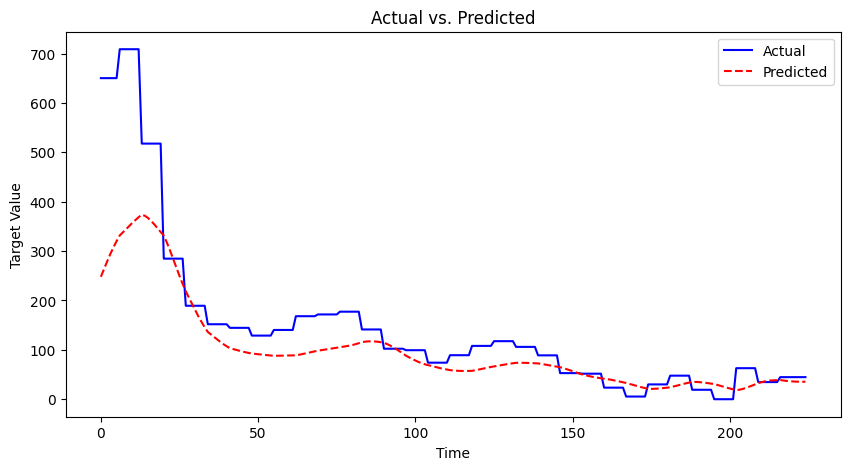

In [340]:
if __name__ == "__main__":
    # Load Data
    file_path = 'Covid_India.csv'
    df = load_data(file_path)
    features = ['new_cases_smoothed', 'reproduction_rate', 'new_tests_smoothed', 
                'positive_rate', 'new_vaccinations_smoothed', 'stringency_index']
    df_selected = select_features(df, features)

    # Convert to Supervised Learning
    lag = 14
    X, y = timeseries_to_supervised(df_selected[features], lag=lag)

    # Split Data
    X_train, X_test, y_train, y_test = split_train_test(X, y, df_selected['date'])

    # Scale Data
    scaler_X, scaler_y, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale(
        X_train, X_test, y_train, y_test
    )

    # Build Model
    model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train Model
    model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])

    # Make Predictions
    y_pred_scaled = model.predict(X_test_scaled)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"RMSE: {rmse:.4f}")

    # Plot Results
    plot_results(y_test, y_pred)